In [1]:
from time import time
import os
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN, FitnessCNNParallel
from utils.datamanager import DataManager
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA
from time import time
import numpy as np

Using TensorFlow backend.


In [2]:
# Chromosome parameters
mutation_rate = 0.05
mutation_rate_1 = mutation_rate * 2
ChromosomeCNN.grow_prob = mutation_rate
ChromosomeCNN.decrease_prob = mutation_rate

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1



In [5]:
fitness = FitnessCNN()

l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness)

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.25
generations = 30
population = 20
train_time = 8
maximize_fit = False
stat_val=True
folder = "../delete"
save_progress = True
age_survivors_rate = 0.2

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(population//4)}
p = ps[parents_selector_key]

# Fitness params
epochs = 75
batch_size = 128
verbose = 0
redu_plat = False
early_stop = 15
warm_up_epochs= 3
base_lr = 0.001
smooth = 0.1
cosine_dec = True
fitness_folder = '../tmp'
fitness_file = os.path.join(fitness_folder, 'fitness_example')    

# dataset params:
dataset = 'MBI'
data_folder = '../datasets'
classes = []

# Load data
dm = DataManager(dataset, clases=classes, folder_var_mnist=data_folder)
data = dm.load_data()
fitness.set_params(data, verbose=verbose, batch_size=batch_size, reduce_plateau=redu_plat,
                   epochs=epochs, cosine_decay=cosine_dec, early_stop=early_stop, 
                   warm_epochs=warm_up_epochs, base_lr=base_lr, smooth_label=smooth)

fitness.save(fitness_file)

del dm, data, fitness

(9600, 28, 28, 1) train samples
(2400, 28, 28, 1) validation samples
(50000, 28, 28, 1) test samples


In [6]:
fitness = FitnessCNNParallel()
fitness.set_params(chrom_files_folder=fitness_folder, fitness_file=fitness_file, max_gpus=2,
                   fp=16, main_line='python3 /home/fondef/daniel/NeuroEvolution/train_gen.py')

In [7]:
generational = GenerationalGA(fitness=fitness, num_parents=num_parents, chromosome=c, parent_selector=p,
                              generations=generations, num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                             save_progress=save_progress, age_survivors_rate=age_survivors_rate)

Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 30
Population size: 20
Folder to save: ../delete/10_2019-05-31-01:43/GA_experiment
num parents: 5
offspring size: 15



Creating Initial population

Start evolution process...

1) best fit: 0.061 in batch time: 7.87 mins
Current winner:
CNN|F:106|K:(7,3)|A:relu|D:0.816|M:1
CNN|F:148|K:(3,5)|A:relu|D:0.152|M:0

Saving... Elapsed saved time: 0.229
Saving... Elapsed saved time: 0.462
Saving... Elapsed saved time: 0.485
4) best fit: 0.047 in batch time: 27.36 mins
Current winner:
CNN|F:106|K:(7,3)|A:relu|D:0.654|M:1
CNN|F:116|K:(3,3)|A:relu|D:0.615|M:1

Saving... Elapsed saved time: 0.455
Saving... Elapsed saved time: 0.451
Saving... Elapsed saved time: 0.613
7) best fit: 0.047 in batch time: 54.41 mins
Current winner:
CNN|F:106|K:(7,3)|A:relu|D:0.654|M:1
CNN|F:116|K:(3,3)|A:relu|D:0.615|M:1

Saving... Elapsed saved time: 0.577
Saving... Elapsed saved time: 0.591
Saving... Elapsed saved time: 0.570
10) best fit: 0.039 in batch time: 90.56 mins
Current winner:
CNN|F:114|K:(3,3)|A:relu|D:0.623|M:1
CNN|F:92|K:(3,3)|A:relu|D:0.624|M:0
NN|U:154|A:relu|D:0.827

Saving... Elapsed saved time: 0.550
Saving... Elapse

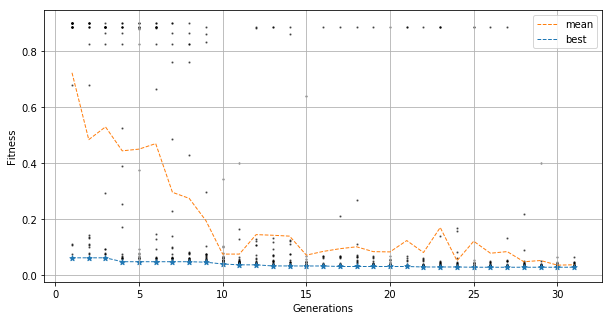

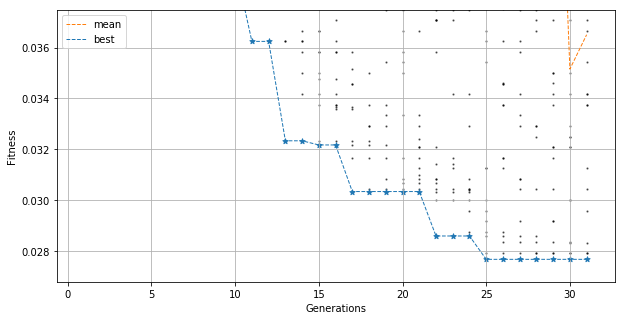

Total elapsed time: 24339.651


In [8]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))

In [ ]:
generational = GenerationalGA.load_genetic_algorithm(folder=folder)

In [ ]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))


In [ ]:
l1 = CNNLayer(104, (5,3), 'prelu', 0.046, True)
l2 = CNNLayer(132, (1,1), 'leakyreLu', 0.597, 0)
l3 = CNNLayer(127, (5,5), 'prelu', 0.286, 1)
l4 = CNNLayer(104, (3,4), 'relu', 0.346, 1)
l5 = CNNLayer(160, (5,1), 'sigmoid', 0.413, 1)
l6 = NNLayer(118, 'elu', 0.354)
best = Cromosome([l1,l2,l3,l4,l5], [l6])

l1_ = CNNLayer(32, (3,3), 'relu', 0.2, False)
l2_ = CNNLayer(64, (3,3), 'relu', 0.2, True)
l3_ = NNLayer(128, 'relu', 0.5)
base = Cromosome([l1_, l2_], [l3_])

nn = Cromosome([],[NNLayer(830, 'prelu', 0.654), NNLayer(782, 'tanh', 0.166), NNLayer(28, 'elu', 0.062)])

In [ ]:
s = fitness.calc(base, lr=0.001, test=True)